# Описание проекта

## Прогнозирование температуры звезды

Имеется задача от обсерватории "Небо на ладони": придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Задача:**

Разработать и обучить нейронную сеть для предсказания температуры звезды по входным данным.

# Подготовка среды

In [1]:
import pandas as pd #'2.2.3'
import matplotlib #'3.10.1'
import matplotlib.pyplot as plt
import seaborn as sns #'0.13.2'
import numpy as np # '2.2.3'
import sklearn #'1.6.1'
from time import time
import os
# import re
# import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer


import torch #2.6.0+cpu
from torch import nn

from IPython.display import clear_output

# убрать предупреждения
import warnings
warnings.filterwarnings('ignore')

# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# необходимо для показа всех столбцов.
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Объявление констант и определение функций

In [2]:
L0 = 3.828 * 10 ** 26 # светимость солнца в ваттах
R0 = 6.9551 * 10 ** 8 # радиус солнца в метрах
random_state = 13

In [3]:
def num_plots(col, title, bins=50):
    '''Построение графиков для анализа количествнных данных'''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))
    
    fig.suptitle(title)
    
    
    ax1.boxplot(data[col], vert=False)
    ax1.set(ylabel='item', xlabel='value')
    
    ax2.hist(data[col], bins=bins, rwidth=0.8)
    ax2.set(ylabel='count of entries', xlabel='value')
    
    clear_output()
    plt.show()

In [4]:
def rmse_loss(y_pred, y_true):
    l = nn.MSELoss()
    lv = torch.sqrt(l(y_pred, y_true))
    return lv.float()

In [5]:
# mse_loss = nn.MSELoss()

def net_improver(num_epochs):
    for epoch in range(num_epochs):
        reg_net.train()
        optimizer.zero_grad()
        preds = reg_net.forward(x_train_tensor)
        loss_val = rmse_loss(preds, torch.from_numpy(np.array(y_train)).float())
#         loss_val = mse_loss(preds, torch.from_numpy(np.array(y_train)).float())
        loss_val.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            reg_net.eval()
            with torch.no_grad():
                test_preds = reg_net.forward(x_test_tensor)
                rmse = rmse_loss(test_preds, torch.from_numpy(np.array(y_test))).data
            print(f'epochs: {epoch}    rmse: {rmse}')

# Загрузка и описание данных

- **id** уникальный идентификатор в таблице.
- **lumin** Относительная светимость L/Lo — светимость звезды относительно Солнца.
- **radius** Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- **abs_magn** Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- **star_color** Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- **star_type** Тип звезды.
- **temp** Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.


|Тип звезды | Номер, соответствующий типу|
|----|----|
|Коричневый карлик | 0|
|Красный карлик | 1|
|Белый карлик | 2|
|Звёзды главной последовательности | 3|
|Сверхгигант | 4|
|Гипергигант | 5|

In [6]:
if os.path.exists('6_class.csv'):
    data = pd.read_csv('6_class.csv')
elif os.path.exists('/datasets/6_class.csv'):
    data = pd.read_csv('/datasets/6_class.csv')
else:
    raise FileNotFoundError('csv file not found')

In [7]:
data.columns = ['id', 'temp', 'lumin', 'radius', 'abs_magn', 'star_type', 'star_color']

In [8]:
data.head()

,id,temp,lumin,radius,abs_magn,star_type,star_color
0,0,3068,0.00,0.17,16.12,0,Red
1,1,3042,0.00,0.15,16.60,0,Red
2,2,2600,0.00,0.10,18.70,0,Red
3,3,2800,0.00,0.16,16.65,0,Red
4,4,1939,0.00,0.10,20.06,0,Red


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          240 non-null    int64  
 1   temp        240 non-null    int64  
 2   lumin       240 non-null    float64
 3   radius      240 non-null    float64
 4   abs_magn    240 non-null    float64
 5   star_type   240 non-null    int64  
 6   star_color  240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


In [10]:
data['star_type'] = data['star_type'].astype('object')

**Промежуточный вывод:**

На этапе загрузки и ознакомления с данными был произведён общий осмотр данных и информации о признаках.

# Предобработка данных

In [11]:
data.isna().sum()

id            0
temp          0
lumin         0
radius        0
abs_magn      0
star_type     0
star_color    0
dtype: int64

In [12]:
data.duplicated().sum()

np.int64(0)

**Промежуточный вывод:**

Предобработка данных показала чистоту данных: ни пропусков, ни дубликатов в датасете нет.

# EDA

In [13]:
data.describe()

,id,temp,lumin,radius,abs_magn
count,240.00,240.00,240.00,240.00,240.00
mean,119.50,"10,497.46","107,188.36",237.16,4.38
std,69.43,"9,552.43","179,432.24",517.16,10.53
min,0.00,"1,939.00",0.00,0.01,-11.92
25%,59.75,"3,344.25",0.00,0.10,-6.23
50%,119.50,"5,776.00",0.07,0.76,8.31
75%,179.25,"15,055.50","198,050.00",42.75,13.70
max,239.00,"40,000.00","849,420.00","1,948.50",20.06


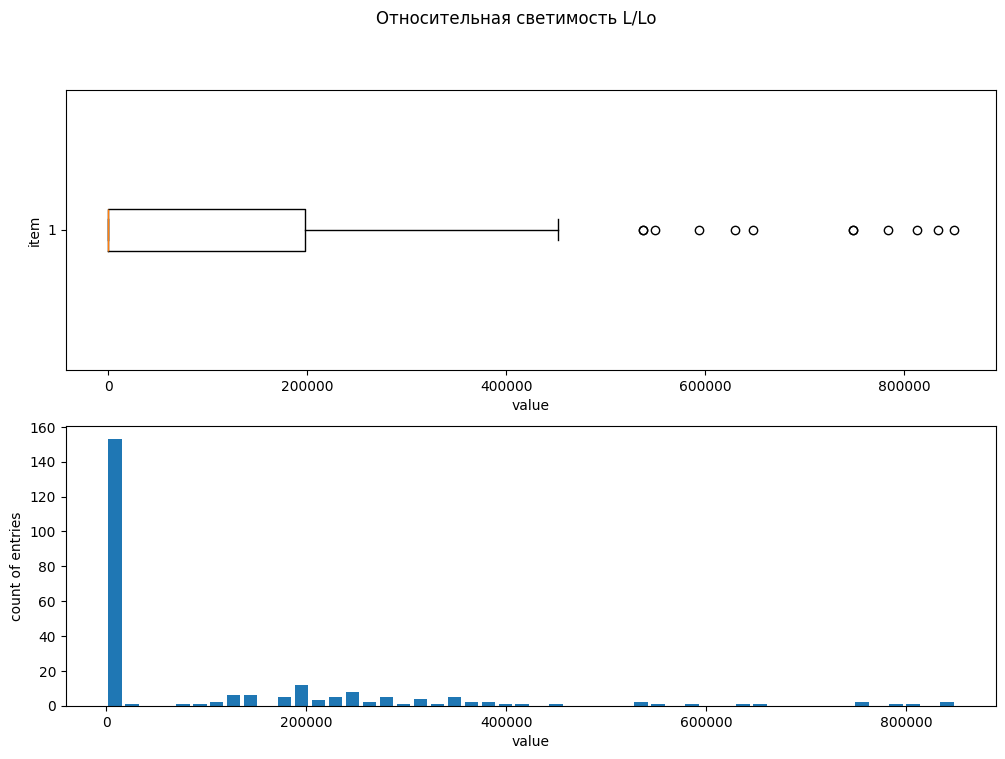

In [14]:
num_plots('lumin', 'Относительная светимость L/Lo')

Большая часть звёзд в данных имеет сопоставимую с солнцем светимость.

---

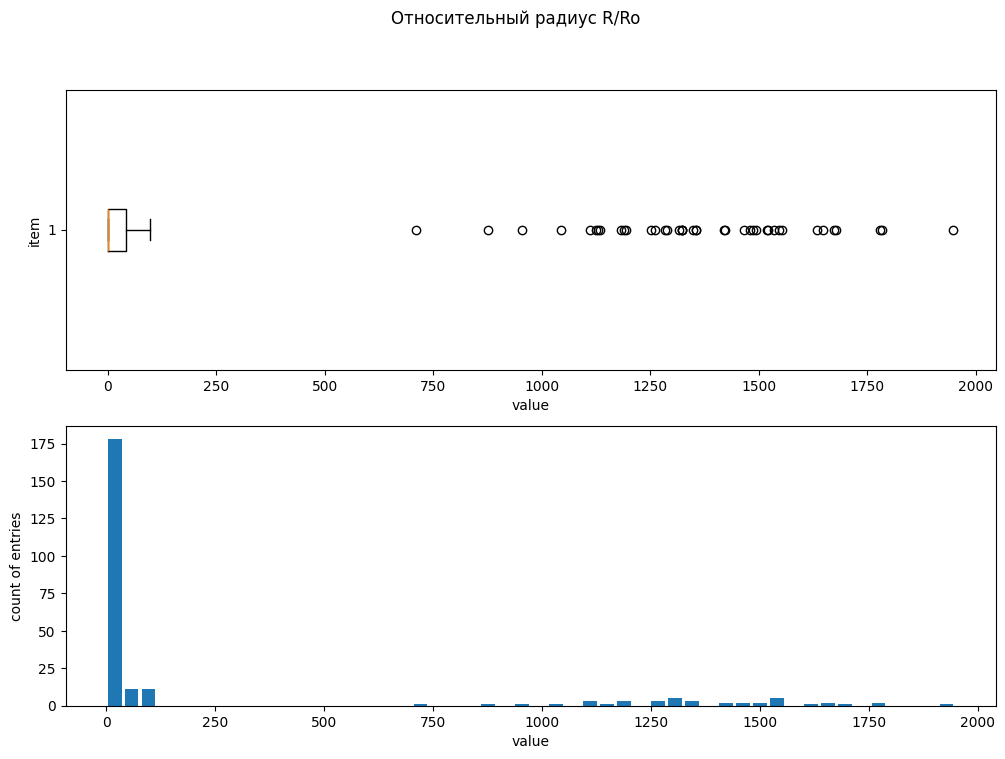

In [15]:
num_plots('radius', 'Относительный радиус R/Ro')

Большая часть звёзд в данных имеет сопоставимый с солнцем радиус.

---

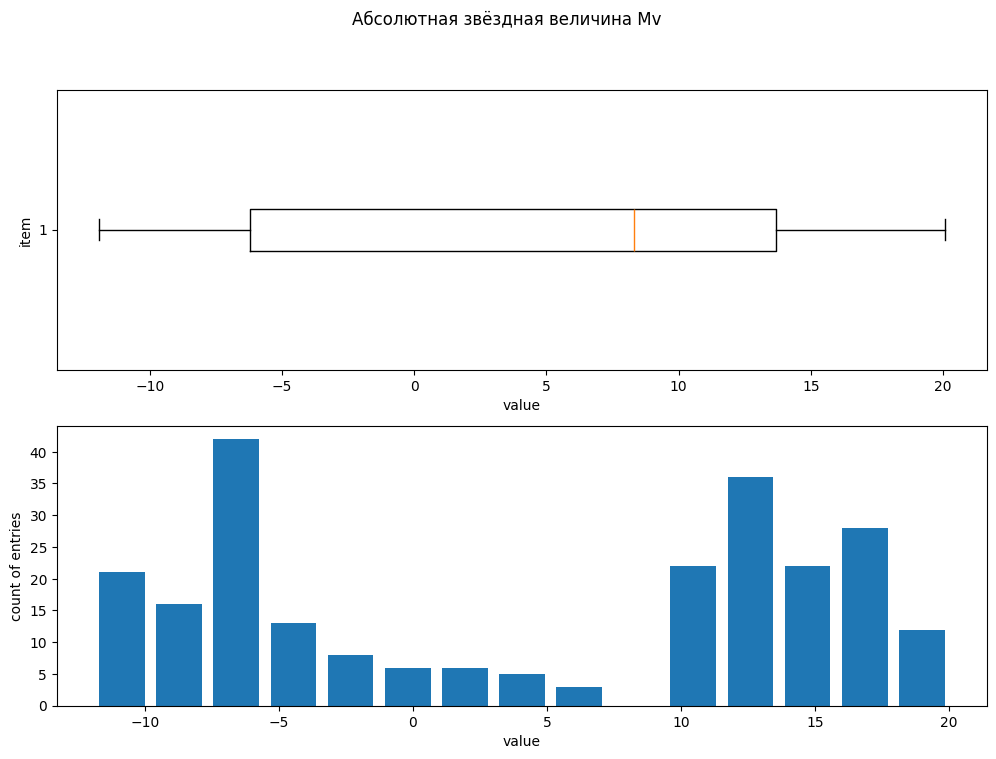

In [16]:
num_plots('abs_magn', 'Абсолютная звёздная величина Mv', bins=15)

Данный признак имеет необычное распределение с "седлом" по середине значений данных.

---

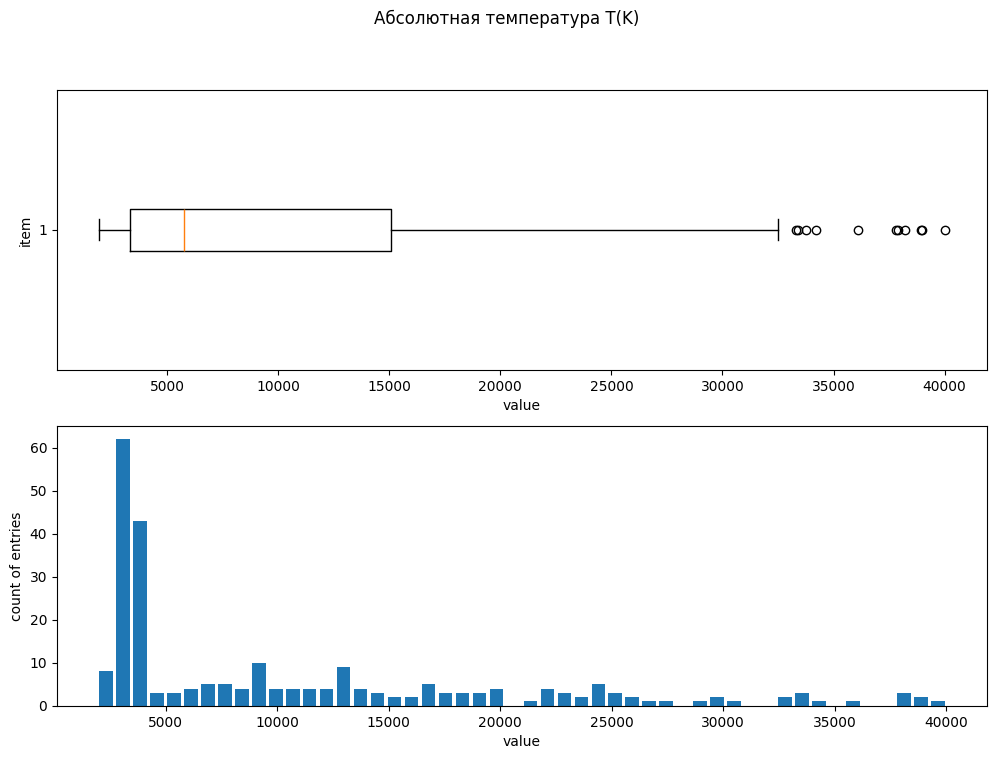

In [17]:
num_plots('temp', 'Абсолютная температура T(K)')

Целевой признак показывает те же тендеции, что и остальные числовые признаки. 

---

---

---

In [18]:
data.describe(include='object')

,star_type,star_color
count,240,240
unique,6,19
top,0,Red
freq,40,112


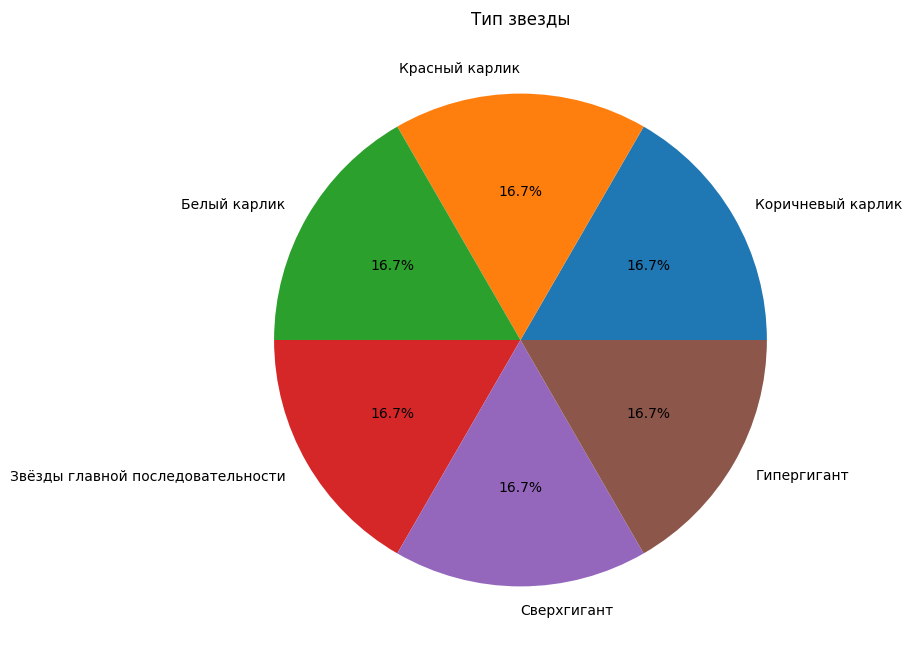

In [19]:
col = 'star_type'
title = 'Тип звезды'


stt_labels = ['Коричневый карлик',
 'Красный карлик',
 'Белый карлик',
 'Звёзды главной последовательности',
 'Сверхгигант',
 'Гипергигант']


strt = data['star_type'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(strt['count'], labels=stt_labels, autopct='%1.1f%%')
ax.set(title=title)

clear_output()
plt.show()

В данных по типам звёзд абсолютное равномерное распределение типов. 

---

In [20]:
sorted(data['star_color'].unique().tolist())
# данные содержат неявные дубликаты по цвету звезды.
data.loc[data['star_color'] == 'Blue ', 'star_color'] = 'Blue'
data.loc[data['star_color'].isin(['Blue White', 'Blue white', 'Blue white ', 'Blue-White', 'Blue-white']), 'star_color'] = 'blue_white'
data.loc[data['star_color'].isin(['White-Yellow', 'Yellowish White', 'yellow-white',]), 'star_color'] = 'yellow_white'
data.loc[data['star_color'].isin(['White', 'Whitish', 'white']), 'star_color'] = 'white'
data.loc[data['star_color'].isin(['yellowish', 'Yellowish']), 'star_color'] = 'yellow'

['Blue',
 'Blue ',
 'Blue White',
 'Blue white',
 'Blue white ',
 'Blue-White',
 'Blue-white',
 'Orange',
 'Orange-Red',
 'Pale yellow orange',
 'Red',
 'White',
 'White-Yellow',
 'Whitish',
 'Yellowish',
 'Yellowish White',
 'white',
 'yellow-white',
 'yellowish']

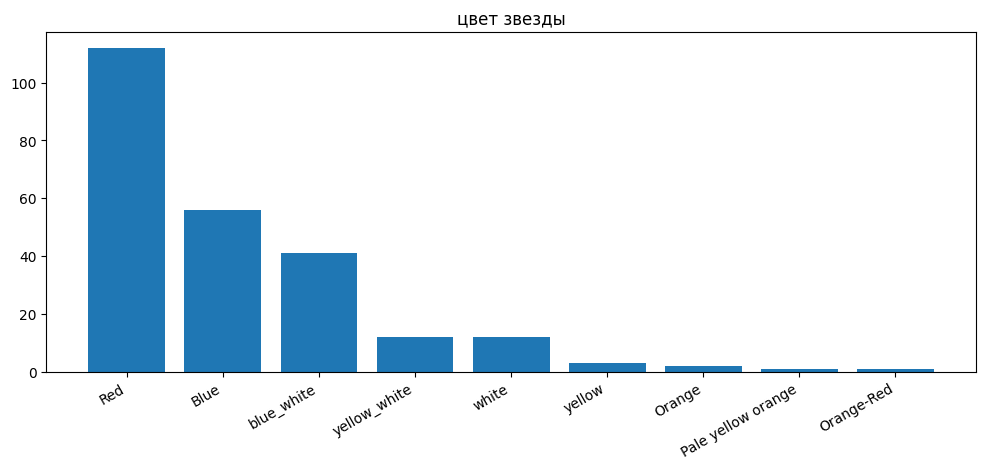

In [21]:
col = 'star_color'
title = 'цвет звезды'

strc = data['star_color'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(strc['star_color'], strc['count'])
fig.autofmt_xdate()
ax.set(title=title)

clear_output()
plt.show()

Тип цвета звезды в данных имеет большое разнообразие и неравномерное количество записей по каждому цвету.

---

**Промежуточный вывод:**

Исследовательский анализ данных показал общую тенденцию и распределение числовых и категориальных признаков, а также целевого признака.

# Построение базовой НС

In [22]:
df = data.drop('id', axis=1)

In [86]:
x = df[['lumin', 'radius', 'abs_magn', 'star_type', 'star_color']]
y = df['temp']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=x['star_type'], test_size=0.3, random_state=random_state)

In [87]:
target = 'temp'
cat_cols = ['star_type', 'star_color']
num_cols = ['lumin', 'radius', 'abs_magn']

data_preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(categories=[x[cat_cols[0]].unique().tolist(), x[cat_cols[1]].unique().tolist()], sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [88]:
x_train_prep = data_preprocessor.fit_transform(x_train)
x_test_prep = data_preprocessor.transform(x_test)

In [89]:
x_train_tensor = torch.from_numpy(x_train_prep).float()
x_test_tensor = torch.from_numpy(x_test_prep).float()

In [90]:
class Net(nn.Module):
    '''Класс полносвязной нейронной сети'''
    
    def __init__(self, arch_net):
        super(Net, self).__init__()
        
        net_layers = []
        
        for i in range(len(arch_net)-1):
            net_layers.append(nn.Linear(arch_net[i][0], arch_net[i+1][0]))
            if arch_net[i][1] != None:
                net_layers.append(arch_net[i][1])
        
        self.net = nn.Sequential(*net_layers)
        
        self.net.apply(self.init_weights)
    
    def forward(self, x):
        return self.net.forward(x)
    
    def init_weights(self, layer):
        '''Инициализация весов слоёв'''
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, mean=0.0, std=1)
            nn.init.normal_(layer.bias, mean=0.0, std=0.5)

In [117]:
arch_net = [
    (18, nn.Sigmoid()),
    (32, nn.ReLU()),
    (16, None),
    (1, None)
]

In [118]:
reg_net = Net(arch_net)
optimizer = torch.optim.Adam(reg_net.parameters(), lr=5.0e-2)

In [119]:
num_epochs = 2001

net_improver(num_epochs)

epochs: 0    rmse: 13535.81640625
epochs: 100    rmse: 8847.6455078125
epochs: 200    rmse: 8849.7724609375
epochs: 300    rmse: 8849.529296875
epochs: 400    rmse: 8849.5302734375
epochs: 500    rmse: 8849.5302734375
epochs: 600    rmse: 8849.5302734375
epochs: 700    rmse: 8849.5302734375
epochs: 800    rmse: 8849.5302734375
epochs: 900    rmse: 8849.5302734375
epochs: 1000    rmse: 8849.53125
epochs: 1100    rmse: 8849.53125
epochs: 1200    rmse: 8849.53125
epochs: 1300    rmse: 8849.53125
epochs: 1400    rmse: 8849.53125
epochs: 1500    rmse: 8849.53125
epochs: 1600    rmse: 8849.53125
epochs: 1700    rmse: 8849.5302734375
epochs: 1800    rmse: 8849.53125
epochs: 1900    rmse: 8849.53125
epochs: 2000    rmse: 8849.53125


In [94]:
root_mean_squared_error(y_test, reg_net.forward(x_test_tensor).detach().numpy())

8849.4306640625

# Улучшение НС

# Выводы